In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [78]:
def rectangular_wave(t: np.ndarray,
                     height: float = 1.0,
                     width: float = 1.0,
                     duty: float = 0.5,
                     phase: float = 0.0) -> np.ndarray:
    """
    Generate a rectangular (pulse) wave.

    Parameters
    ----------
    t : np.ndarray
        1D array of time points.
    height : float, optional
        Amplitude of the pulse. Default is 1.0.
    width : float, optional
        Period of the rectangular wave. Default is 1.0.
    duty : float, optional
        Duty cycle (0 < duty < 1). Default is 0.5.
    phase : float, optional
        Time shift applied to the wave. Positive shifts to the right. Default is 0.0.

    Returns
    -------
    np.ndarray
        Array of same shape as `t`, containing values 0 or `height`.
    """
    # Apply phase shift to time axis
    t_shifted = t + phase
    # Compute position within each period
    phase_in_cycle = np.mod(t_shifted, width)
    # Determine where the wave is high (True) vs. low (False)
    mask = phase_in_cycle < (duty * width)
    # Convert boolean mask to float amplitude
    return mask.astype(float) * height

Text(0, 0.5, 'Amplitude')

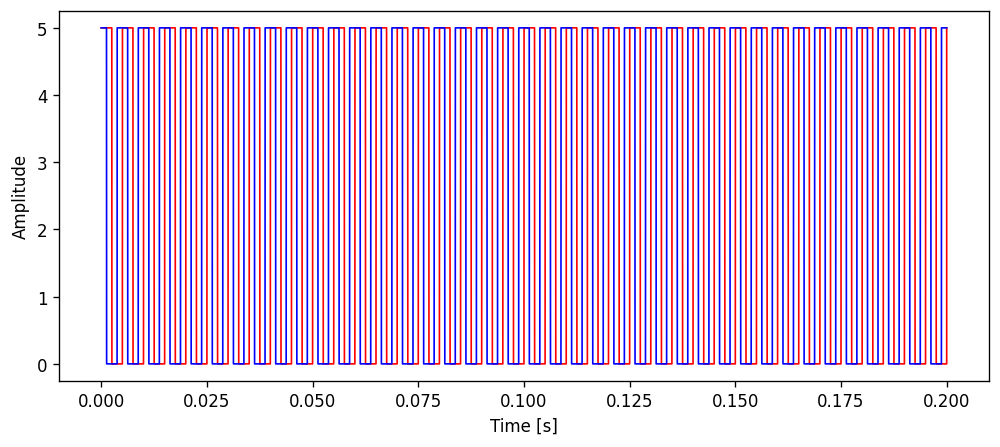

In [79]:
import numpy as np

t = np.linspace(0, 0.2, 200000)  
dA = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.0)
dB = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.00125)

fig, ax = plt.subplots(figsize=(10, 4), dpi=120)
ax.plot(t, dA, lw=1.0, color='red')
ax.plot(t, dB, lw=1.0, color='blue')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

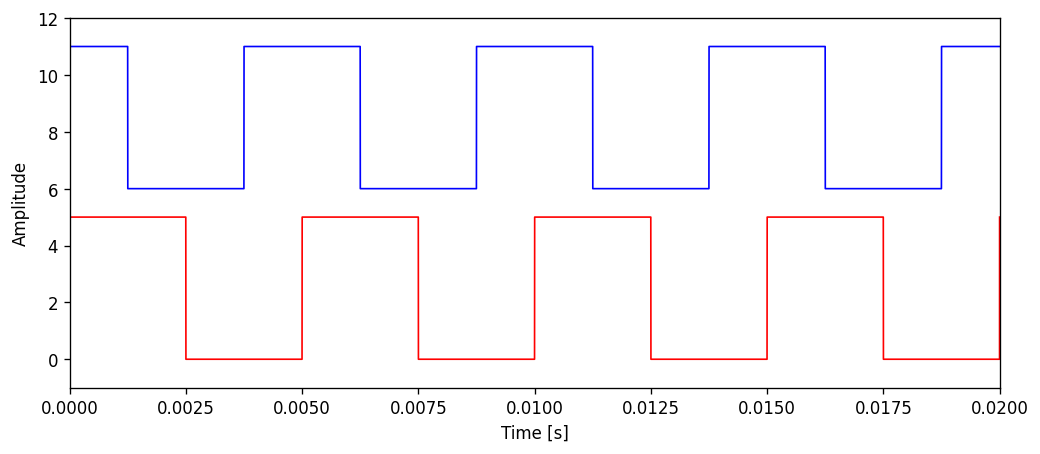

In [80]:
t = np.linspace(0, 0.2, 200000)   # 0 から 5 秒、1000 サンプル
dA = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.0)
dB = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.00125)

fig, ax = plt.subplots(figsize=(10, 4), dpi=120)
ax.plot(t, dA, lw=1.0, color='red')
ax.plot(t, dB+6, lw=1.0, color='blue')
ax.set_xlim(0, 0.02)
ax.set_ylim(-1, 12)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')

In [81]:
def quad_freq_from_two(dA: np.ndarray, dB: np.ndarray, height: float = 1.0) -> np.ndarray:
    """
    Create a 4x frequency rectangular wave by XOR of two phase-shifted waves.

    Parameters
    ----------
    dA : np.ndarray
        First pulse wave (values 0 or height).
    dB : np.ndarray
        Second pulse wave (values 0 or height).
    height : float, optional
        Desired output amplitude. Default is 1.0.

    Returns
    -------
    np.ndarray
        4x frequency pulse wave (0 or height).
    """
    # Perform logical XOR on the two input waves
    return ((dA > 0) ^ (dB > 0)).astype(float) * height

In [82]:
# ---------- util functions ----------
def rectangular_wave(t, height=1.0, width=1.0, duty=0.5, phase=0.0):
    mod = (t + phase) % width
    return np.where(mod < duty * width, height, 0.0)

def both_edge_detector(x):
    """Return rising, falling, and both-edge boolean arrays."""
    s = (np.asarray(x) != 0).astype(int)
    d = np.roll(s, 1); d[0] = s[0]
    rising  = (s & ~d).astype(bool)
    falling = (~s &  d).astype(bool)
    edges   = rising | falling
    return edges, rising, falling

def edge_to_pulse(x, pulse_len=100, edge_type='both', amplitude=1):
    """
    Generate fixed-length rectangular pulses triggered by input edges.

    Parameters
    ----------
    x : array-like
        Input digital signal (0/1 or any numeric).
    pulse_len : int
        Pulse length in *samples*.
    edge_type : {'both', 'rising', 'falling'}
        Which edge(s) should trigger the one-shot.
    amplitude : scalar
        High-level of the output pulse.

    Returns
    -------
    y : ndarray
        Output signal with rectangular pulses.
    """
    edges, rising, falling = both_edge_detector(x)
    if edge_type == 'rising':
        trg = rising
    elif edge_type == 'falling':
        trg = falling
    else:
        trg = edges

    # Convolve trigger with a "box" of ones then clip
    box = np.ones(pulse_len, dtype=int)
    y = np.convolve(trg.astype(int), box, mode='full')[:len(x)]
    return (y > 0) * amplitude


[]

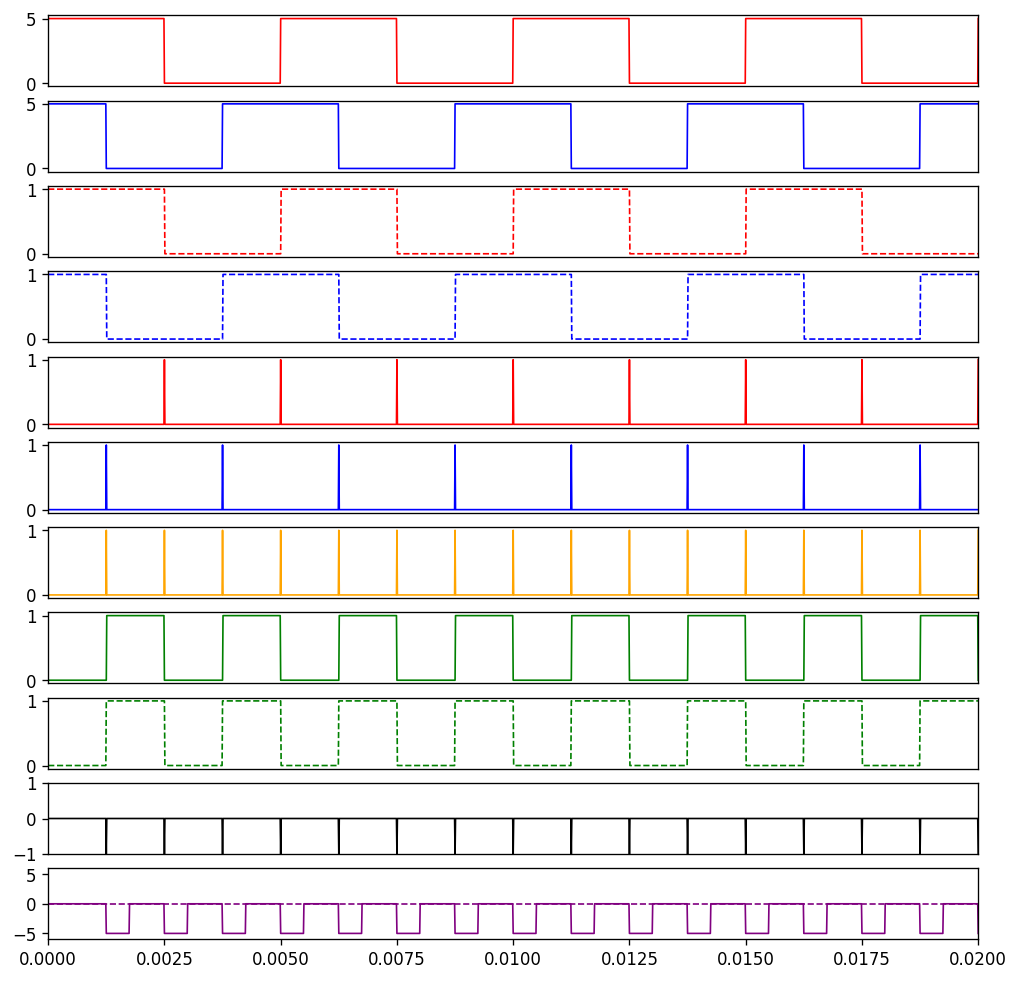

In [95]:
def rectangular_wave(t, height=1.0, width=1.0, duty=0.5, phase=0.0):
    mod = (t + phase) % width
    return np.where(mod < duty * width, height, 0.0)


sampling_rate = 20000 # 20 kHz
t = np.linspace(0, 0.2, sampling_rate)

dA = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.0)
dB = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.00125)

dA_log = (dA > 2.5)
dB_log = (dB > 2.5)

#==========================
prevA = np.concatenate([[dA_log[0]], dA_log[:-1]])
prevB = np.concatenate([[dB_log[0]], dB_log[:-1]])


edge = (dA_log ^ prevA) | (dB_log ^ prevB) # self XOR (edge detection)
dir_log   = (prevB^dA_log).astype(int) - (prevA^dB_log).astype(int) # direction of edge
#direction = np.where(edge, np.where(dir_sig, 1, -1), 0)



width   = int(0.0025*sampling_rate)
height  = 5.0         # 出力パルスの高さ
base_sig    = np.full(width, height, dtype=float)
edge_sig = np.convolve(dir_log, base_sig, mode='full')[:len(t)]


# pulse_count = np.cumsum(direction)
fig, ax = plt.subplots(11,1,figsize=(10, 10), dpi=120)
ax[0].plot(t, dA, lw=1.0, color='red')
ax[1].plot(t, dB, lw=1.0, color='blue')
ax[2].plot(t, prevA, lw=1.0, color='red', ls='--')
ax[3].plot(t, prevB, lw=1.0, color='blue', ls='--')
ax[4].plot(t, dA_log ^ prevA, lw=1.0, color='red', ls='-')
ax[5].plot(t, dB_log ^ prevB, lw=1.0, color='blue', ls='-')
ax[6].plot(t, edge, lw=1.0, color='orange')
ax[7].plot(t, prevB^dA_log, lw=1.0, color='green')
ax[8].plot(t, prevA^dB_log, lw=1.0, color='green', ls='--')
ax[9].plot(t, dir_log, lw=1.0, color='black')
ax[10].plot(t, edge_sig, lw=1.0, color='purple')
ax[10].axhline(0, color='purple', lw=1.0, ls='--')


ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[2].set_xlim(0, 0.02)
ax[3].set_xlim(0, 0.02)
ax[4].set_xlim(0, 0.02)
ax[5].set_xlim(0, 0.02)
ax[6].set_xlim(0, 0.02)
ax[7].set_xlim(0, 0.02)
ax[8].set_xlim(0, 0.02)
ax[9].set_xlim(0, 0.02)
ax[9].set_ylim(-1, 1)
ax[10].set_xlim(0, 0.02)
ax[10].set_ylim(-6, 6)


ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[5].set_xticks([])
ax[6].set_xticks([])
ax[7].set_xticks([])
ax[8].set_xticks([])
ax[9].set_xticks([])


In [89]:
prevB^dA_log

array([False, False, False, ...,  True,  True, False])

[]

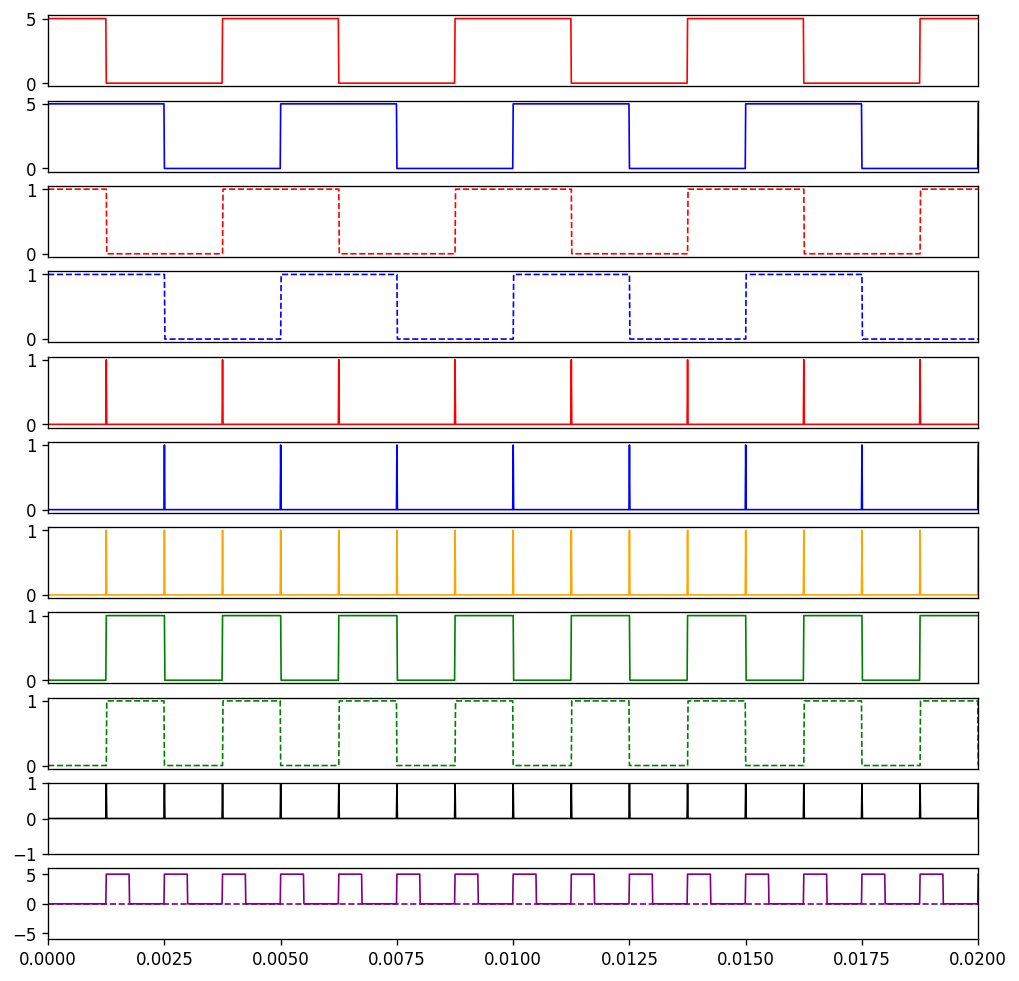

In [96]:
def rectangular_wave(t, height=1.0, width=1.0, duty=0.5, phase=0.0):
    mod = (t + phase) % width
    return np.where(mod < duty * width, height, 0.0)


sampling_rate = 20000 # 20 kHz
t = np.linspace(0, 0.2, sampling_rate)

dA = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.00125)
dB = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.0)

dA_log = (dA > 2.5)
dB_log = (dB > 2.5)

#==========================
prevA = np.concatenate([[dA_log[0]], dA_log[:-1]])
prevB = np.concatenate([[dB_log[0]], dB_log[:-1]])


edge = (dA_log ^ prevA) | (dB_log ^ prevB) # self XOR (edge detection)
dir_log   = (prevB^dA_log).astype(int) - (prevA^dB_log).astype(int) # direction of edge
#direction = np.where(edge, np.where(dir_sig, 1, -1), 0)



width   = int(0.0025*sampling_rate)
height  = 5.0         # 出力パルスの高さ
base_sig    = np.full(width, height, dtype=float)
edge_sig = np.convolve(dir_log, base_sig, mode='full')[:len(t)]


# pulse_count = np.cumsum(direction)
fig, ax = plt.subplots(11,1,figsize=(10, 10), dpi=120)
ax[0].plot(t, dA, lw=1.0, color='red')
ax[1].plot(t, dB, lw=1.0, color='blue')
ax[2].plot(t, prevA, lw=1.0, color='red', ls='--')
ax[3].plot(t, prevB, lw=1.0, color='blue', ls='--')
ax[4].plot(t, dA_log ^ prevA, lw=1.0, color='red', ls='-')
ax[5].plot(t, dB_log ^ prevB, lw=1.0, color='blue', ls='-')
ax[6].plot(t, edge, lw=1.0, color='orange')
ax[7].plot(t, prevB^dA_log, lw=1.0, color='green')
ax[8].plot(t, prevA^dB_log, lw=1.0, color='green', ls='--')
#ax[9].plot(t, direction, lw=1.0, color='black')
ax[9].plot(t, dir_log, lw=1.0, color='black')
ax[10].plot(t, edge_sig, lw=1.0, color='purple')
ax[10].axhline(0, color='purple', lw=1.0, ls='--')


ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[2].set_xlim(0, 0.02)
ax[3].set_xlim(0, 0.02)
ax[4].set_xlim(0, 0.02)
ax[5].set_xlim(0, 0.02)
ax[6].set_xlim(0, 0.02)
ax[7].set_xlim(0, 0.02)
ax[8].set_xlim(0, 0.02)
ax[9].set_xlim(0, 0.02)
ax[9].set_ylim(-1, 1)
ax[10].set_xlim(0, 0.02)
ax[10].set_ylim(-6, 6)


ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[5].set_xticks([])
ax[6].set_xticks([])
ax[7].set_xticks([])
ax[8].set_xticks([])
ax[9].set_xticks([])


36
36
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1]


Text(0.5, 1.0, 'Clockwise')

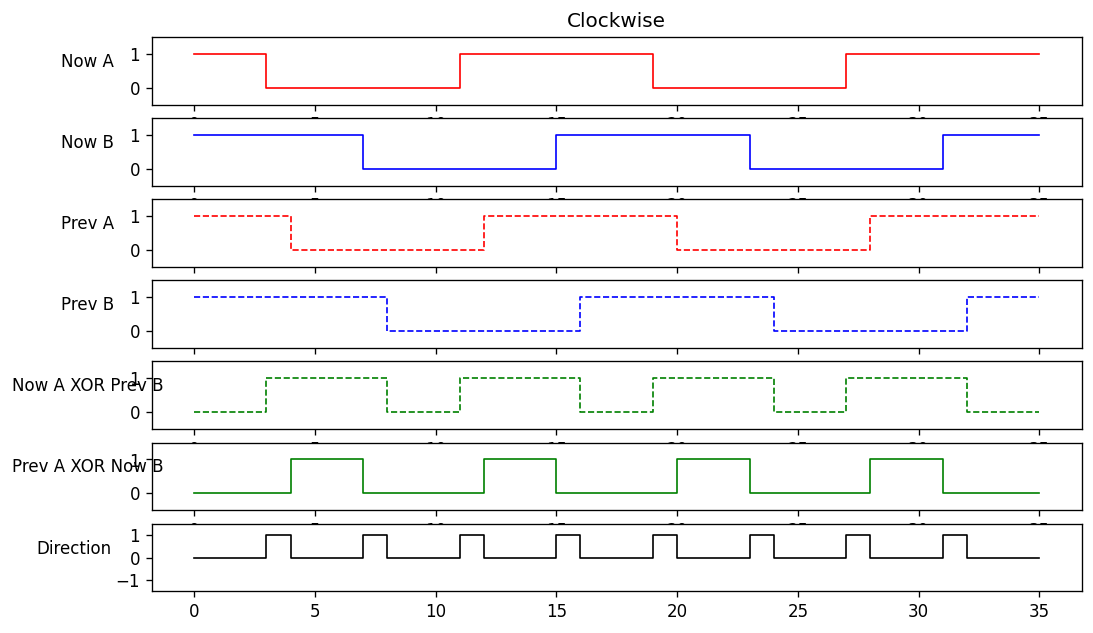

In [100]:
import numpy as np
import matplotlib.pyplot as plt

nowA_cw = np.array([1, 0, 0, 1, 1, 0, 0, 1, 1])
nowA_cw = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,])
print(len(nowA_cw))
nowB_cw = np.array([1, 1, 0, 0, 1, 1, 0, 0, 1])
nowB_cw = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
print(len(nowB_cw))
t = np.arange(len(nowA_cw))
print(nowB_cw)
print(np.concatenate(([nowB_cw[0]], nowB_cw[:-1])))

fig, ax = plt.subplots(7,1,figsize=(10, 6), dpi=120)
ax[0].step(t, nowA_cw, lw=1.0, color='red')
ax[0].set_ylabel("Now A", rotation=0, labelpad=25)
ax[0].set_ylim(-0.5, 1.5)
ax[1].step(t, nowB_cw, lw=1.0, color='blue')
ax[1].set_ylabel("Now B", rotation=0, labelpad=25)
ax[1].set_ylim(-0.5, 1.5)
ax[2].step(t, np.concatenate(([nowA_cw[0]], nowA_cw[:-1])), lw=1.0, color='red', ls='--')
ax[2].set_ylabel("Prev A", rotation=0, labelpad=25)
ax[2].set_ylim(-0.5, 1.5)
ax[3].step(t, np.concatenate(([nowB_cw[0]], nowB_cw[:-1])), lw=1.0, color='blue', ls='--')
ax[3].set_ylabel("Prev B", rotation=0, labelpad=25)
ax[3].set_ylim(-0.5, 1.5)

ax[4].step(t, nowA_cw ^ np.concatenate(([nowB_cw[0]], nowB_cw[:-1])), lw=1.0, color='green', ls='--')
ax[4].set_ylabel("Now A XOR Prev B", rotation=0, labelpad=25)
ax[4].set_ylim(-0.5, 1.5)
ax[5].step(t, np.concatenate(([nowA_cw[0]], nowA_cw[:-1])) ^ nowB_cw, lw=1.0, color='green')
ax[5].set_ylabel("Prev A XOR Now B", rotation=0, labelpad=25)
ax[5].set_ylim(-0.5, 1.5)
ax[6].step(t, (nowA_cw ^ np.concatenate(([nowB_cw[0]], nowB_cw[:-1]))) - (np.concatenate(([nowA_cw[0]], nowA_cw[:-1])) ^ nowB_cw), lw=1.0, color='black')
ax[6].set_ylabel("Direction", rotation=0, labelpad=25)
ax[6].set_ylim(-1.5, 1.5)



ax[0].set_title('Clockwise')

#plt.tight_layout()


Text(0.5, 1.0, 'CounterClockwise')

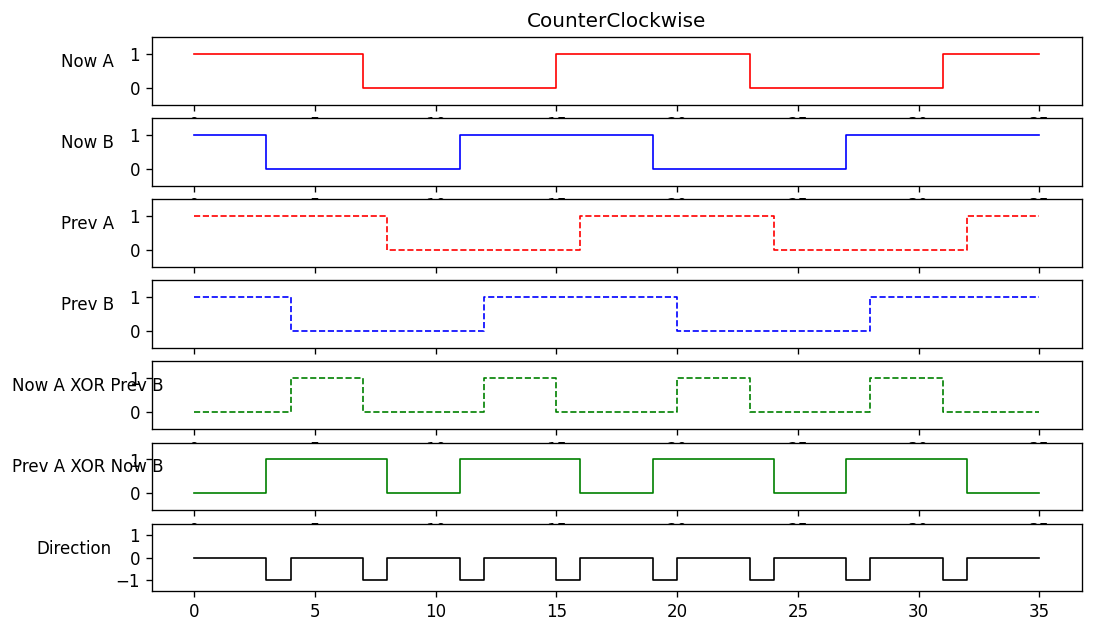

In [101]:
nowA_ccw = np.array([1, 1, 0, 0, 1, 1, 0, 0, 1])
nowA_ccw = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
nowB_ccw = np.array([1, 0, 0, 1, 1, 0, 0, 1, 1])
nowB_ccw = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,])
t = np.arange(len(nowA_ccw))    


fig, ax = plt.subplots(7,1,figsize=(10, 6), dpi=120)
ax[0].step(t, nowA_ccw, lw=1.0, color='red')
ax[0].set_ylabel("Now A", rotation=0, labelpad=25)
ax[0].set_ylim(-0.5, 1.5)
ax[1].step(t, nowB_ccw, lw=1.0, color='blue')
ax[1].set_ylabel("Now B", rotation=0, labelpad=25)
ax[1].set_ylim(-0.5, 1.5)
ax[2].step(t, np.concatenate(([nowA_ccw[0]], nowA_ccw[:-1])), lw=1.0, color='red', ls='--')
ax[2].set_ylabel("Prev A", rotation=0, labelpad=25)
ax[2].set_ylim(-0.5, 1.5)
ax[3].step(t, np.concatenate(([nowB_ccw[0]], nowB_ccw[:-1])), lw=1.0, color='blue', ls='--')
ax[3].set_ylabel("Prev B", rotation=0, labelpad=25)
ax[3].set_ylim(-0.5, 1.5)

ax[4].step(t, nowA_ccw ^ np.concatenate(([nowB_ccw[0]], nowB_ccw[:-1])), lw=1.0, color='green', ls='--')
ax[4].set_ylabel("Now A XOR Prev B", rotation=0, labelpad=25)
ax[4].set_ylim(-0.5, 1.5)
ax[5].step(t, np.concatenate(([nowA_ccw[0]], nowA_ccw[:-1])) ^ nowB_ccw, lw=1.0, color='green')
ax[5].set_ylabel("Prev A XOR Now B", rotation=0, labelpad=25)
ax[5].set_ylim(-0.5, 1.5)
ax[6].step(t, (nowA_ccw ^ np.concatenate(([nowB_ccw[0]], nowB_ccw[:-1]))) - (np.concatenate(([nowA_ccw[0]], nowA_ccw[:-1])) ^ nowB_ccw), lw=1.0, color='black')
ax[6].set_ylabel("Direction", rotation=0, labelpad=25)
ax[6].set_ylim(-1.5, 1.5)



ax[0].set_title('CounterClockwise')

#plt.tight_layout()

In [107]:
import numpy as np

THRESHOLD_DEFAULT = 2.5  # V

def gen_pulse_binarize(signal: np.ndarray, threshold: float = THRESHOLD_DEFAULT) -> np.ndarray:
    """Return a boolean array where *True* represents a logic‑high level.

    Parameters
    ----------
    signal : np.ndarray
        Input analogue signal (voltage).
    threshold : float, optional
        Voltage threshold separating logic high and low. Defaults to 2.5 V.

    Returns
    -------
    np.ndarray
        Boolean array of the same length as *signal*.
    """
    return signal > threshold


def gen_pulse_shift(values: np.ndarray) -> np.ndarray:
    """Return array shifted right by one sample (previous value)."""
    return np.concatenate([[values[0]], values[:-1]])


def gen_pulse_direction(
    chan_a: np.ndarray,
    chan_b: np.ndarray,
    threshold: float = THRESHOLD_DEFAULT,
) -> np.ndarray:
    """Compute signed edges (+1 = CW, −1 = CCW, 0 = no edge).

    Parameters
    ----------
    chan_a, chan_b : np.ndarray
        Analogue quadrature signals A and B.
    threshold : float, optional
        Logic threshold for binarisation.

    Returns
    -------
    np.ndarray
        Signed edge array.
    """
    a_logic = gen_pulse_binarize(chan_a, threshold)
    b_logic = gen_pulse_binarize(chan_b, threshold)

    prev_a = gen_pulse_shift(a_logic)
    prev_b = gen_pulse_shift(b_logic)

    cw_edges = prev_b ^ a_logic  # A rising AFTER B ⇒ clockwise
    ccw_edges = prev_a ^ b_logic  # B rising AFTER A ⇒ counter‑clockwise

    return cw_edges.astype(int) - ccw_edges.astype(int)


def pulse_count(direction: np.ndarray) -> int:
    """Return total signed pulse count (quadrature ×4)."""
    return int(np.sum(direction))


def gen_quad_pulse(
    time: np.ndarray,
    direction: np.ndarray,
    width: float,
    amplitude: float,
    sampling_rate: float,
) -> np.ndarray:
    """Generate a rectangular pulse train for each edge in *direction*.

    Parameters
    ----------
    time : np.ndarray
        Global time axis (seconds).
    direction : np.ndarray
        Signed edge array produced by :func:`direction_from_quadrature`.
    width : float
        Pulse width in seconds.
    amplitude : float
        Pulse amplitude.
    sampling_rate : float
        Sampling frequency in Hz.

    Returns
    -------
    np.ndarray
        Pulse train aligned with *time*.
    """
    width_samples = int(width * sampling_rate)
    base_pulse = np.full(width_samples, amplitude)
    pulses = np.convolve(direction, base_pulse, mode="full")[: len(time)]
    return pulses


160


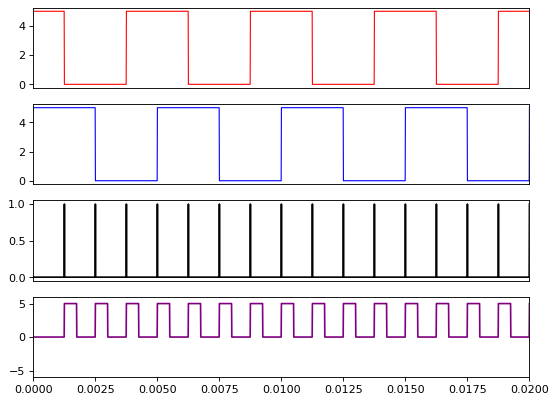

In [116]:
def rectangular_wave(t, height=1.0, width=1.0, duty=0.5, phase=0.0):
    mod = (t + phase) % width
    return np.where(mod < duty * width, height, 0.0)


sampling_rate = 20000 # 20 kHz
t = np.linspace(0, 0.2, sampling_rate)

dA = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.00125)
dB = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.0)


d_direction = gen_pulse_direction(dA, dB, threshold=THRESHOLD_DEFAULT)
count = pulse_count(d_direction)
d_quad = gen_quad_pulse(t, d_direction, 0.0025, 5, sampling_rate)


# pulse_count = np.cumsum(direction)
fig, ax = plt.subplots(4,1,figsize=(8, 6), dpi=80)
ax[0].plot(t, dA, lw=1.0, color='red')
ax[1].plot(t, dB, lw=1.0, color='blue')
ax[2].plot(t, d_direction, color='black')
ax[3].plot(t, d_quad, color = 'purple')

ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[2].set_xlim(0, 0.02)
ax[3].set_xlim(0, 0.02)
ax[3].set_ylim(-6, 6)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])


print(count)

-160


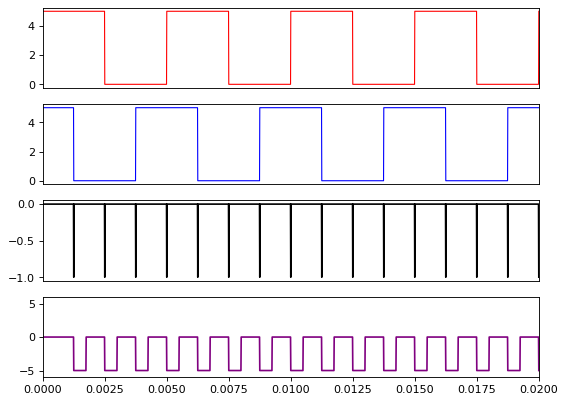

In [ ]:
def rectangular_wave(t, height=1.0, width=1.0, duty=0.5, phase=0.0):
    mod = (t + phase) % width
    return np.where(mod < duty * width, height, 0.0)


sampling_rate = 20000 # 20 kHz
t = np.linspace(0, 0.2, sampling_rate)

'''
of you set 1 pulse = 0.5 ms, you will have 40 pulses within 0.2 s window, and thus x4 should be equivalent to 160 pulses.
'''

dA = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.0)
dB = rectangular_wave(t, height=5, width=0.005, duty=0.50, phase=0.00125)


d_direction = gen_pulse_direction(dA, dB, threshold=THRESHOLD_DEFAULT)
count = pulse_count(d_direction)
d_quad = gen_quad_pulse(t, d_direction, 0.0025, 5, sampling_rate)


# pulse_count = np.cumsum(direction)
fig, ax = plt.subplots(4,1,figsize=(8, 6), dpi=80)
ax[0].plot(t, dA, lw=1.0, color='red')
ax[1].plot(t, dB, lw=1.0, color='blue')
ax[2].plot(t, d_direction, color='black')
ax[3].plot(t, d_quad, color = 'purple')

ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[2].set_xlim(0, 0.02)
ax[3].set_xlim(0, 0.02)
ax[3].set_ylim(-6, 6)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])


print(count)